# This notebook contains:
* Diurnal cycle plots of BARRA-2 surface winds vs station data for different regimes
* Barb and diurnal cycle plots of wind direction and speed barra vs station + function for circmean wind direction calculation

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings
import sys
import metpy
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import metpy.calc as mpcalc
import pandas as pd
from netCDF4 import Dataset
import os
import glob
from datetime import datetime
import seaborn as sns
import netCDF4
from netCDF4 import Dataset
from metpy.units import units
import dask
import xarray as xr
from shapely import Polygon
import regionmask
import geopandas as gpd
import dask
from scipy.stats import circmean

In [2]:
# open netcdf files created in BA_variable-to-netcdf notebook
# mean over radar domain
barra_towns = xr.open_dataset("/home/563/ac9768/barra-2/barra-2_850hPa_winds_townsville.nc", engine="h5netcdf",chunks="auto")
barra_cairns = xr.open_dataset("/home/563/ac9768/barra-2/barra-2_850hPa_winds_cairns.nc", engine="h5netcdf",chunks="auto")
barra_willis = xr.open_dataset("/home/563/ac9768/barra-2/barra-2_850hPa_winds_willis_island.nc", engine="h5netcdf",chunks="auto")
# values over study domain longitude
barra_towns_sfc = xr.open_dataset("/home/563/ac9768/barra-2/barra-2_sfc_winds_townsville.nc", engine="h5netcdf",chunks="auto")
barra_cairns_sfc = xr.open_dataset("/home/563/ac9768/barra-2/barra-2_sfc_winds_cairns.nc", engine="h5netcdf",chunks="auto")
barra_willis_sfc = xr.open_dataset("/home/563/ac9768/barra-2/barra-2_sfc_winds_willis.nc", engine="h5netcdf",chunks="auto")
# barra surface winds for townsville and cairns station coordinates
barra_station_towns_sfc = xr.open_dataset("/home/563/ac9768/barra-2/barra-2_sfc-winds-station_towns.nc", engine="h5netcdf",chunks="auto")
barra_station_cairns_sfc = xr.open_dataset("/home/563/ac9768/barra-2/barra-2_sfc-winds-station_cairns.nc", engine="h5netcdf",chunks="auto")

## Regimes for stations

In [8]:
def calc_mean_wdir(ds):
    radian = np.deg2rad(ds)
    circmean_ds = circmean(radian,high=(2*np.pi),low=0,nan_policy='omit')
    wdir_mean = np.rad2deg(circmean_ds)
    return wdir_mean
# print('Mean Cairns wind direction: ',calc_mean_wdir(wdir_maskC))

Mean Cairns wind direction:  152.30076022623825


In [10]:
# select regime
def regime(barra_site,deg1,deg2,variable_ds,ne=None,all_winds=None,wind_direction=None):
    winds = barra_site.wind_dir.compute()
    if ne==True:
        winds_dir = winds[(winds>=deg1)&(winds<=deg2)]
    else:
        winds_dir = winds[(winds>deg1)&(winds<=deg2)]
    if all_winds==True:
        winds_dir = winds
    else:
        pass
    # now that the regime composite times have been defined, calculate the diurnal mean of variable in question 
    regime = variable_ds.sel(time=winds_dir.time.values)
    if wind_direction == True:
        group_values = regime.groupby(regime.time.dt.hour)
        mean_values = []
        for hour in np.arange(0,24,1):
            calc = calc_mean_wdir(group_values[hour])
            mean_values.append(calc)
    else:
        mean_values = regime.groupby(regime.time.dt.hour).mean(dim='time')
    # shift from utc to aest
    aest = np.roll(mean_values,shift=10,axis=0)
    # for plotting, double array to show 48 hours
    double = np.concatenate([aest,aest]) 
    return aest

In [74]:
# from above function calc regime mean for variable: regime(barra_site,deg1,deg2,variable_ds,ne=None,all_winds=None)
sfc_ne_station = regime(barra_cairns,0,90,barra_station_cairns_sfc.wind_dir,ne=True,all_winds=False,wind_direction=True)
sfc_se_station = regime(barra_cairns,90,180,barra_station_cairns_sfc.wind_dir,ne=False,all_winds=False,wind_direction=True)
sfc_sw_station = regime(barra_cairns,180,270,barra_station_cairns_sfc.wind_dir,ne=False,all_winds=False,wind_direction=True)
sfc_nw_station = regime(barra_cairns,270,360,barra_station_cairns_sfc.wind_dir,ne=False,all_winds=False,wind_direction=True)
# sfc_clim = regime(barra_towns,270,360,barra_station_towns_sfc.wind_dir,ne=False,all_winds=True,wind_direction=True)
sfc_ne_speed = regime(barra_cairns,0,90,barra_station_cairns_sfc.wind_speed,ne=True,all_winds=False,wind_direction=False)
sfc_se_speed = regime(barra_cairns,90,180,barra_station_cairns_sfc.wind_speed,ne=False,all_winds=False,wind_direction=False)
sfc_sw_speed = regime(barra_cairns,180,270,barra_station_cairns_sfc.wind_speed,ne=False,all_winds=False,wind_direction=False)
sfc_nw_speed = regime(barra_cairns,270,360,barra_station_cairns_sfc.wind_speed,ne=False,all_winds=False,wind_direction=False)
# sfc_clim_speed = regime(barra_towns,270,360,barra_station_towns_sfc.wind_speed,ne=False,all_winds=True,wind_direction=False)

In [35]:
# Weather station - Cairns, file path
station_fp = '/g/data/w40/clv563/BoM_data/AWS-data-QLD.nc'
# open with xarray and dask chunking
station_ds = xr.open_dataset(station_fp, engine="h5netcdf", chunks="auto")
bmid_cairns = station_ds.bmid[21]     # BOM ID: 031011
# cairns
cairns_wdir = station_ds.wdir.sel(station=21) * units("degrees")
cairns_wspd = (station_ds.wspd.sel(station=21) * (1000/(60*60))) *  units("m/s")
towns_wdir = station_ds.wdir.sel(station=30) * units("degrees")
towns_wspd = (station_ds.wspd.sel(station=30) * (1000/(60*60))) *  units("m/s")

In [36]:
def JFMA_data(ds):
    var_jan_to_apr = [] # to append data
    years = np.arange(2012,2022,1)#(1990,2021,1) # available years of data
    for year in years:
        year_str = str(year)
        var_jfma = ds.sel(time=slice(year_str+'-01-01',year_str+'-04-30'))
        var_jan_to_apr.append(var_jfma)
    return xr.concat(var_jan_to_apr, dim='time').compute()
# cairns variables
wdirC = JFMA_data(cairns_wdir)
wspdC = JFMA_data(cairns_wspd)
wdirT = JFMA_data(towns_wdir)
wspdT = JFMA_data(towns_wspd)

In [37]:
def wind_masks(ds_wdir,ds_wdspd):
    calm = ds_wdspd[ds_wdspd==0*units('m/s')]
    northerly = ds_wdir[ds_wdir==0*units('degrees')]
    calm_mask = xr.where(ds_wdspd==0*units('m/s'), np.nan, ds_wdspd)
    wdir_mask = xr.where(np.isnan(calm_mask), np.nan, ds_wdir)
    return wdir_mask,calm_mask
wdir_maskC,wspd_maskC = wind_masks(wdirC,wspdC)
wdir_maskT,wspd_maskT = wind_masks(wdirC,wspdC)

In [63]:
len(barra_wdir.time)/24

1262.0

[264.41765975 258.22256889 268.88228121 262.79562643 254.04795727
 240.7851779  242.91188025 261.42346875 270.6268208  294.90409983
 335.29991496 358.4532727    3.55599136   9.63577048   9.6387843
   7.93703072   7.11564924   3.33117461 344.18814941 326.51686542
 305.97706591 285.44059953 284.25968714 268.07727511]


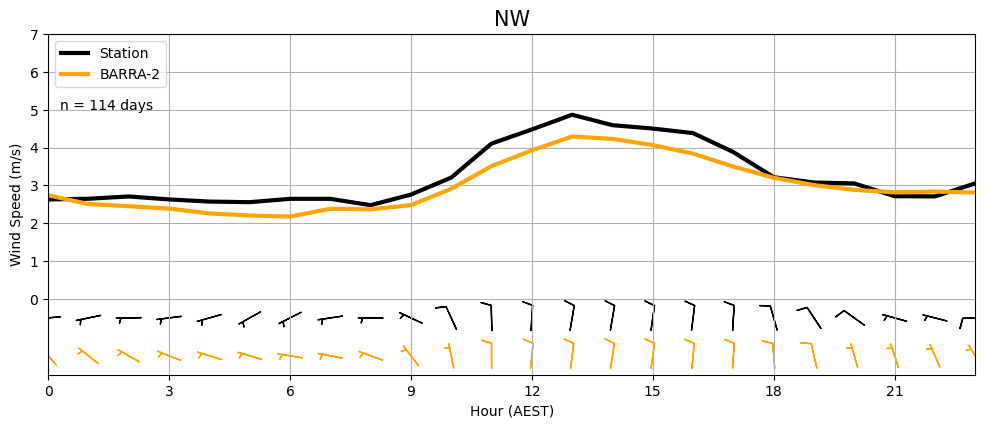

In [79]:
# make sure correct barra site for regimes is selected here:
barra_wdir = barra_cairns.wind_dir.compute()
# 2. Classify wind regimes and their time periods
barra_wdir_NE = barra_wdir[(barra_wdir>=0)&(barra_wdir<=90)]
barra_wdir_SE = barra_wdir[(barra_wdir>90)&(barra_wdir<=180)]
barra_wdir_SW = barra_wdir[(barra_wdir>180)&(barra_wdir<=270)]
barra_wdir_NW = barra_wdir[(barra_wdir>270)&(barra_wdir<=360)]

def calc_mean_and_plot(station_site_wdir,station_site_wspd,regime,barra_sfc_station_wdir,barra_sfc_station_wspd,title,sample_size,color):
    fig,ax = plt.subplots(1, figsize=[10,4])
    fig.patch.set_facecolor('white')
    # fig.suptitle('Cairns Station vs BARRA-2',fontsize=20)
    fig.tight_layout()
    
    # define station and barra wind direction and speed arrays for composites
    # 2. Station data set to only look at the hourly values
    station_hourly_wdir = station_site_wdir.isel(time=station_site_wdir['time.minute'] == 0)
    station_hourly_wspd = station_site_wspd.isel(time=station_site_wspd['time.minute'] == 0)
    # 3. Select station dataset times to align with barra wind regimes
    station_wdir = station_hourly_wdir.sel(time=regime.time.values,method='nearest')
    station_wspd = station_hourly_wspd.sel(time=regime.time.values,method='nearest')
    # 4. Group station datasets by hour 
    wdir = station_wdir.groupby(station_wdir.time.dt.hour)
    wdspd = station_wspd.groupby(station_wspd.time.dt.hour).mean(dim="time")
    # 5. Calculate circ mean for wind direction, regular mean for speed above
    deg = []
    for hour in np.arange(0,24,1):
        wdir_deg = calc_mean_wdir(wdir[hour])
        deg.append(wdir_deg)
    # wdir_mean = np.roll(deg,shift=10,axis=0)
    # 6. Change to AEST
    aest_dir = np.roll(deg,shift=10)
    aest_speed = np.roll(wdspd,shift=10,axis=0)       
    # plot
    ax.plot(np.arange(0,24,1),aest_speed,label='Station',color="black",linewidth=3)
    ax.plot(np.arange(0,24,1),barra_sfc_station_wspd,label='BARRA-2',color=color,linewidth=3)
    ax.set_title(title,fontsize=15)
    ax.set_xlabel('Hour (AEST)')
    ax.set_ylabel('Wind Speed (m/s)')
    ax.set_xlim(0,23)
    ax.set_ylim(-2,7)
    ax.set_yticks([0,1,2,3,4,5,6,7])
    ax.annotate(xy=(0.3,5),text=sample_size)
    ax.set_xticks(np.arange(0,23,3))
    ax.grid()
    plt.legend(loc='upper left')
    # station barbs
    print(aest_dir)
    wind_direction_degrees = np.array(aest_dir + 180) # 180 is added so that the direction plotted for barbs is the direction "from"
    wind_direction_radians = np.radians(90 - wind_direction_degrees)
    ax.barbs(range(len(wind_direction_degrees)), [-0.5] * len(wind_direction_degrees), aest_speed * np.cos(wind_direction_radians), aest_speed * np.sin(wind_direction_radians),
              barb_increments=dict(half=2, full=4, flag=20), length=6,pivot='middle',flip_barb=True)
    # barra barbs
    wind_direction_degrees_barra = np.array(barra_sfc_station_wdir + 180)
    wind_direction_radians_barra = np.radians(90 - wind_direction_degrees_barra)
    ax.barbs(range(len(wind_direction_degrees_barra)), [-1.5] * len(wind_direction_degrees_barra), barra_sfc_station_wspd * np.cos(wind_direction_radians_barra), barra_sfc_station_wspd * np.sin(wind_direction_radians_barra),
              barb_increments=dict(half=2, full=4, flag=20), length=6,pivot='middle',flip_barb=True,color=color)
    return

# for station inputs, make sure the wind direction mask (removes calm conditions) and wind speed masks have been applied
# calc_mean_and_plot(wdir_maskC,wspd_maskC,barra_wdir_NE,sfc_ne_station,sfc_ne_speed,'NE','n = 160 days','seagreen')
# calc_mean_and_plot(wdir_maskC,wspd_maskC,barra_wdir_SE,sfc_se_station,sfc_se_speed,'SE','n = 841 days','royalblue')
# calc_mean_and_plot(wdir_maskC,wspd_maskC,barra_wdir_SW,sfc_sw_station,sfc_sw_speed,'SW','n = 146 days','purple')
calc_mean_and_plot(wdir_maskC,wspd_maskC,barra_wdir_NW,sfc_nw_station,sfc_nw_speed,'NW','n = 114 days','orange')

# towns
# calc_mean_and_plot(wdir_maskT,wspd_maskT,barra_wdir_NE,sfc_ne_station,sfc_ne_speed,'NE','n = 255 days','seagreen')
# calc_mean_and_plot(wdir_maskT,wspd_maskT,barra_wdir_SE,sfc_se_station,sfc_se_speed,'SE','n = 826 days','royalblue')
# calc_mean_and_plot(wdir_maskT,wspd_maskT,barra_wdir_SW,sfc_sw_station,sfc_sw_speed,'SW','n = 105 days','purple')
# calc_mean_and_plot(wdir_maskT,wspd_maskT,barra_wdir_NW,sfc_nw_station,sfc_nw_speed,'NW','n = 75 days','orange')

# climatologies
# calc_mean_and_plot(wdir_maskC,wspd_maskC,barra_wdir,sfc_clim,sfc_clim_speed,'Cairns Climatology','n = 1262 days','red')
# calc_mean_and_plot(wdir_maskT,wspd_maskT,barra_wdir,sfc_clim,sfc_clim_speed,'Townsville Climatology','n = 1262 days','red')


# Plotting climatological means

In [ ]:
#plot diurnal cycle
fig,ax = plt.subplots(4,1, figsize=[6,6])
fig.patch.set_facecolor('white')
fig.suptitle('Cairns BoM Station',fontsize=20)
fig.tight_layout()

# plot wind direction as arrows
wind_direction_degrees = np.array(mean_hourly_wdir_AEST + 180)
wind_direction_radians = np.radians(90 - wind_direction_degrees)
wind_speed = np.array(mean_hourly_wspd_AEST_T)

# plot wind barbs
# barb_length = 5  # Adjust the barb length as needed
# ax[0].barbs(range(len(wind_direction_degrees)), [0] * len(wind_direction_degrees), wind_speed * np.cos(wind_direction_radians), wind_speed * np.sin(wind_direction_radians),
#           barb_increments=dict(half=2, full=4, flag=20), length=barb_length,pivot='middle',flip_barb=True)

In [56]:
def diurnal_cycle(ds,winds=None):
    morning = [18,19,20]
    four_am = ds.sel(time=ds.time.dt.hour.isin(morning)) #18 UTC = 4am AEST
    afternoon = [4,5,6] #2-4pm
    four_pm = ds.sel(time=ds.time.dt.hour.isin(afternoon)) #6 UTC = 4pm AEST
    
    # create for loop 
    hourly = ds.groupby(ds.time.dt.hour)
    mean_hourly = []
    if winds==True:
        for hour in range(len(hourly)):
            print(len(hourly[hour]))
            values = hourly[hour].values
            mean = calc_mean_wdir(values)
            mean_hourly.append(mean) 
    else:
        for hour in range(len(hourly)):
            values = hourly[hour].dropna(dim='time').values
            mean = np.mean(values)
            mean_hourly.append(mean) 
    mean_hourly_AEST = np.roll(mean_hourly, shift=10)
    return mean_hourly_AEST, four_am, four_pm 

In [57]:
# townsville
mean_hourly_wdir_AEST_T,four_am_wdirT,four_pm_wdirT = diurnal_cycle(wind_dir_towns,winds=True)
mean_hourly_wspd_AEST_T,four_am_wspdT,four_pm_wspdT = diurnal_cycle(wind_speed_towns,winds=False)
# cairns
# mean_hourly_wdir_AEST_C,four_am_wdirC,four_pm_wdirC = diurnal_cycle(wind_dir_cairns,winds=True)
# mean_hourly_wspd_AEST_C,four_am_wspdC,four_pm_wspdC = diurnal_cycle(wind_speed_cairns,winds=False)

1262
1262
1262
1262
1262
1262
1262
1262
1262
1262
1262
1262
1262
1262
1262
1262
1262
1262
1262
1262
1262
1262
1262
1262


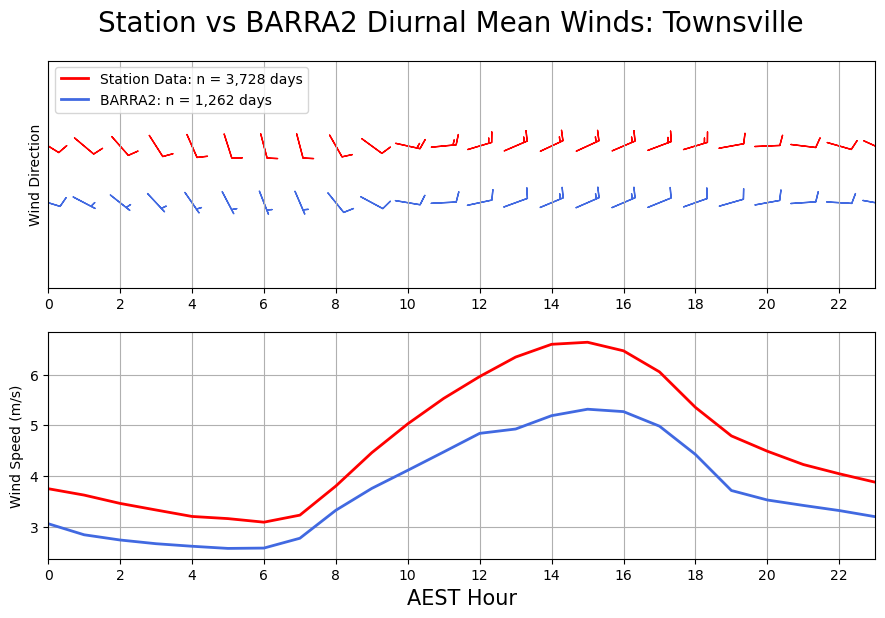

In [84]:
# plot
fig,ax = plt.subplots(2,1, figsize=[9,6])
fig.patch.set_facecolor('white')
fig.suptitle('Station vs BARRA2 Diurnal Mean Winds: Townsville',fontsize=20)
fig.tight_layout()

# plot wind direction as arrows
wind_direction_degrees = np.array(mean_hourly_wdir_AEST_T + 180)
wind_direction_radians = np.radians(90 - wind_direction_degrees)
wind_speed = np.array(mean_hourly_wspd_AEST_T)
station_wind_direction_degrees = np.array(station_mean_hourly_wdir_AEST_T + 180)
station_wind_direction_radians = np.radians(90 - station_wind_direction_degrees)
station_wind_speed = np.array(station_mean_hourly_wspd_AEST_T)

# plot wind barbs
barb_length = 6  # Adjust the barb length as needed
ax[0].barbs(range(len(wind_direction_degrees)), [-0.5] * len(wind_direction_degrees), wind_speed * np.cos(wind_direction_radians), wind_speed * np.sin(wind_direction_radians),
          barb_increments=dict(half=2, full=4, flag=20), length=barb_length,pivot='middle',color='royalblue',flip_barb=True)
ax[0].barbs(range(len(station_wind_direction_degrees)), [0.5] * len(station_wind_direction_degrees), station_wind_speed * np.cos(station_wind_direction_radians), station_wind_speed * np.sin(station_wind_direction_radians),
          barb_increments=dict(half=2, full=4, flag=20), length=barb_length,pivot='middle',color='red',flip_barb=True)
ax[1].plot(np.arange(0,24,1),station_mean_hourly_wspd_AEST_T,linewidth=2,color='red',label='Station Data: n = 3,728 days')
ax[1].plot(np.arange(0,24,1),mean_hourly_wspd_AEST_T,linewidth=2,color='royalblue',label='BARRA2: n = 1,262 days')
ax[0].set_ylabel('Wind Direction')
ax[1].set_ylabel('Wind Speed (m/s)')
ax[0].set_ylim(-2,2)
ax[0].set_xlim(0,23)
ax[1].set_xlim(0,23)
# ax[1].set_ylim(0,7)
ax[0].set_yticks([])
ax[0].set_yticklabels([])
ax[0].set_xticks(np.arange(0,24,2))
ax[1].set_xticks(np.arange(0,24,2))
# ax[0].set_title('Wind Direction')
# ax[1].set_title('Wind Speed')
ax[1].set_xlabel('AEST Hour',fontsize=15)
plt.legend(loc='upper left', bbox_to_anchor=(0, 2.2))
ax[0].grid(axis='both')
ax[1].grid(axis='both')
# plt.annotate('n = 3,728 days',(20,5));